In [4]:
from env import RandomizedGridMaze
from agents_policies import QAgent, DQNAgent
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import random


In [ ]:

def export_to_csv_episode_data(states_per_step, filename='simulation_data.csv'):
    """
    Export episode data to CSV with one line per step, including for each agent:
    - current resource level
    - observation (emotion)
    - action selected
    - personal_reward
    - empathic_reward
    - combined_reward (total internal reward)
    """
    import csv

    # Number of agents
    n_agents = len(states_per_step[0]['observations'])

    # Dynamically construct CSV headers
    fieldnames = ['step', 'resource']
    for i in range(n_agents):
        fieldnames += [
            f'observation_{i}',
            f'action_{i}',
            f'personal_reward_{i}',
            f'empathic_reward_{i}',
            f'combined_reward_{i}'
        ]

    with open(filename, mode='w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for step_data in states_per_step:
            row = {'step': step_data['step'], 'resource': step_data.get('resource', None)}
            obs = step_data['observations']
            acts = step_data['actions']
            personal = step_data['personal_reward']
            empathic = step_data['empathic_reward']
            # combined reward stored as 'internal_total_reward'
            combined = step_data.get('combined_reward', [])

            for i in range(n_agents):
                row[f'observation_{i}'] = obs[i]
                row[f'action_{i}'] = acts[i]
                row[f'personal_reward_{i}'] = personal[i]
                row[f'empathic_reward_{i}'] = empathic[i]
                # safe fallback to 0 if missing
                row[f'combined_reward_{i}'] = combined[i] if i < len(combined) else None

            writer.writerow(row)

    return filename



In [ ]:

def plot_resource_evolution(states_per_step, env, save_path="resource_evolution.png"):
    """
    Generate a static image to visualize the evolution of the ressources
    """
    steps = [step['step'] for step in states_per_step]
    resources = [step['resource'] for step in states_per_step]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, resources, label='Level of ressources', color='green', linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Ressource")
    plt.title(f"Fluctuation of ressources in the environment for agent: {agent_to_test} with empathy level: {alpha} and valuation of last meal: {beta}")
    plt.ylim(0, env.initial_resources * 1.1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()




In [ ]:
def save_q_table_detailed_to_csv(agents, filename="q_table_detailed.csv"):
    """
    Save each Q-value individually with action separation.
    CSV format: agent_id, state, action, expected_reward
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["agent_id", "state", "action", "expected_reward"])

        for agent_idx, agent in enumerate(agents):
            if hasattr(agent, 'q_table'):  # QAgent only
                for state, actions in agent.q_table.items():
                    for action, value in enumerate(actions):
                        writer.writerow([agent_idx, state, action, value])



In [ ]:

def visualize_q_table(filename):
    df = pd.read_csv(filename)
    agent_id = 0
    df_agent = df[df['agent_id'] == agent_id]

    pivot_table = df_agent.pivot(index='state', columns='action', values='expected_reward')

    plt.figure(figsize=(12, 6))
    plt.title(f"Q-table (agent {agent_id})")
    heatmap = plt.imshow(pivot_table.fillna(0), cmap='viridis', aspect='auto')
    plt.colorbar(heatmap, label='Expected Reward')
    plt.xlabel("Action")
    plt.ylabel("State")
    plt.xticks(ticks=range(len(pivot_table.columns)), labels=pivot_table.columns)
    plt.yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index)
    plt.tight_layout()
    plt.show()



In [ ]:

def filename_definer(agent_type,
                     episode_number,
                     emotion_type,
                     see_emotions,
                     alpha,
                     beta,
                     smoothing_type,
                     threshold_value,
                     emotion_rounder,
                     params_DQN,
                     params_QLearning):
    """
    name of the file order : 
    episode number
    agent_to_test = "DQN" or "QLearning"
    emotion_type = can be "average" or "vector"
    see_emotions = "False" or "True"
    alpha = 1  # parameter for the degree of empathy (the higher the value the higher the empathy in range 0 - 1)
    beta = 0.3 # valuation of the last meal
    smoothing_type = linear or sigmoid
    threshold_value  proportion of reward in the history necessary to have a positive emotion
    emotion_rounder = decimale of emotions

    the parameters of the agents are in the order :
Params_QL
    "learning_rate"
    "gamma"
    "epsilon"
    "epsilon_decay"
    "epsilon_min"

params_DQN =
    "learning_rate"
    "gamma"
    "epsilon"
    "epsilon_decay"
    "epsilon_min"
    "batch_size"
    "hidden_size"
    "update_target_every"

    return the filename of one episode with a random 6 int suffix
    """
    if agent_type == "DQN":
        params = params_DQN
        param_order = ["learning_rate", "gamma", "epsilon", "epsilon_decay", "epsilon_min", "batch_size", "hidden_size", "update_target_every"]
    elif agent_type == "QLearning":
        params = params_QLearning
        param_order = ["learning_rate", "gamma", "epsilon", "epsilon_decay", "epsilon_min"]
    else:
        raise ValueError(f"Unknown agent type: {agent_type!r}")

    # Ensure values appear in fixed order (no key names)
    param_values = "_".join(str(params[key]) for key in param_order)

    random_suffix = ''.join(str(random.randint(0, 9)) for _ in range(6))
    see_emotions_str = str(see_emotions)

    filename = (
        f"results_"
        f"{episode_number}_"
        f"{agent_type}_"
        f"{emotion_type}_"
        f"{see_emotions_str}_"
        f"{alpha}_"
        f"{beta}_"
        f"{smoothing_type}_"
        f"{threshold_value}_"
        f"{emotion_rounder}_"
        f"{param_values}_"
        f"{random_suffix}.csv"
    )

    return filename


if __name__ == '__main__':
    for episode_number in range(1, episodes+1):
        states, env, agents = run_simulation()
        filename_data = export_to_csv_episode_data(states,
                                                   filename=filename_definer(agent_type=agent_to_test,
                                                                             episode_number=episode_number,
                                                                             emotion_type=emotion_type,
                                                                             see_emotions=see_emotions,
                                                                             alpha=alpha,
                                                                             beta=beta,
                                                                             smoothing_type=smoothing_type,
                                                                             threshold_value=threshold_value,
                                                                             emotion_rounder=emotion_rounder,
                                                                             params_DQN=params_DQN,
                                                                             params_QLearning=params_QLearning
                                                                             )
                                                        )

        plot_resource_evolution(states,
                                env)


In [ ]:
import csv
import os
from datetime import datetime

def export_simulation_data(results, config, output_dir="simulation_results"):
    """
    Export simulation data to CSV files for detailed analysis.
    
    Args:
        results: Results dictionary from run_simulation
        config: Configuration dictionary
        output_dir: Directory to save CSV files
    """
    # Create timestamp for unique folder name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    agent_type = config.get("agent_type", "DQN")
    empathy_level = config.get("empathy_level", "high_empathy")
    
    # Create folder structure
    folder_name = f"{agent_type}_{empathy_level}_{timestamp}"
    full_path = os.path.join(output_dir, folder_name)
    os.makedirs(full_path, exist_ok=True)
    
    # Export configuration
    with open(os.path.join(full_path, "config.csv"), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Parameter", "Value"])
        for key, value in config.items():
            writer.writerow([key, value])
    
    # Export episode rewards
    with open(os.path.join(full_path, "episode_rewards.csv"), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Episode", "Mean_Reward", "Std_Reward"])
        for i, (mean, std) in enumerate(zip(results['mean_rewards'], results['std_rewards'])):
            writer.writerow([i, mean, std])
    
    # Export social welfare
    with open(os.path.join(full_path, "social_welfare.csv"), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Episode", "Mean_Welfare", "Std_Welfare"])
        for i, (mean, std) in enumerate(zip(results['mean_welfare'], results['std_welfare'])):
            writer.writerow([i, mean, std])
    
    # Export action distribution overall
    with open(os.path.join(full_path, "action_distribution_overall.csv"), 'w', newline='') as f:
        writer = csv.writer(f)
        
        # Prepare header with action names
        header = ["Episode"]
        action_names = list(results['action_analysis']['overall'].keys())
        header.extend(action_names)
        writer.writerow(header)
        
        # Write data for each episode
        num_episodes = len(next(iter(results['action_analysis']['overall'].values())))
        for episode in range(num_episodes):
            row = [episode]
            for action in action_names:
                row.append(results['action_analysis']['overall'][action][episode])
            writer.writerow(row)
    
    # Export action distribution for each agent
    for agent_idx, actions in results['action_analysis']['by_agent'].items():
        with open(os.path.join(full_path, f"agent_{agent_idx+1}_actions.csv"), 'w', newline='') as f:
            writer = csv.writer(f)
            
            # Prepare header with action names
            header = ["Episode"]
            action_names = list(actions.keys())
            header.extend(action_names)
            writer.writerow(header)
            
            # Write data for each episode
            num_episodes = len(next(iter(actions.values())))
            for episode in range(num_episodes):
                row = [episode]
                for action in action_names:
                    row.append(actions[action][episode])
                writer.writerow(row)
    
    print(f"All simulation data exported to {full_path}")
    return full_path

# Now we need to update the run_simulation function to collect all actions data
def run_simulation(config=None):
    """
    Run a full simulation with multiple tests based on configuration.
    
    Args:
        config: Configuration dictionary (uses default_config if None)
        
    Returns:
        Dictionary with combined results from all tests
    """
    if config is None:
        config = default_config
    
    # Set random seed for reproducibility
    np.random.seed(config.get("seed", 42))
    
    # Get agent and environment classes
    agent_type = config.get("agent_type", "DQN")
    env_type = config.get("env_type", "random_Maze")  # Fix env_type to match keys in env_name_to_class
    empathy_level = config.get("empathy_level", "high_empathy")
    
    agent_class = agent_policy_name_to_class[agent_type]
    env_class = env_name_to_class[env_type]
    
    # Get configuration parameters
    agent_config = agent_params[agent_type]
    emotion_config = emotions_params[empathy_level]
    
    env_config = {
        'size': config.get("env_size", 6),
        'nb_agents': config.get("num_agents", 3),
        'agent_configs': [{'memory_size': 10} for _ in range(config.get("num_agents", 3))],
        'reward_density': 0.2,
        'respawn_prob': 0.1,
        'simple_mode': True,
        'auto_consume': True,
        'exploit_only': False,
        'episodes': config.get("episodes", 100),
        'steps_per_episode': config.get("steps_per_episode", 500)
    }
    
    num_tests = config.get("num_tests", 3)
    
    # Storage for results from all tests
    all_rewards = []
    all_welfare = []
    all_actions = []
    
    # Setup logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    
    # Run the specified number of tests
    logging.info(f"Running {num_tests} tests with {agent_type} on {env_type}")
    logging.info(f"Empathy level: {empathy_level} (alpha={emotion_config['alpha']}, beta={emotion_config['beta']})")
    
    for test_idx in range(num_tests):
        logging.info(f"Starting test {test_idx+1}/{num_tests}")
        
        # Run test and collect results
        results = run_single_test(agent_class, env_class, agent_config, env_config, emotion_config)
        
        all_rewards.append(results['episode_rewards'])
        all_welfare.append(results['social_welfare'])
        all_actions.append(results['actions'])
        
        logging.info(f"Test {test_idx+1} completed. Final reward: {results['episode_rewards'][-1]:.2f}")
    
    # Calculate statistics across all tests
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    mean_welfare = np.mean(all_welfare, axis=0)
    std_welfare = np.std(all_welfare, axis=0)
    
    # Flatten all actions data for analysis
    flattened_actions = []
    for episode_idx in range(config.get("episodes", 100)):
        episode_actions = {}
        for agent_idx in range(config.get("num_agents", 3)):
            episode_actions[agent_idx] = [0, 0, 0, 0, 0]  # Initialize counters
            
            # Sum up actions across all tests
            for test_idx in range(num_tests):
                if episode_idx < len(all_actions[test_idx]):
                    for action_idx in range(5):
                        episode_actions[agent_idx][action_idx] += all_actions[test_idx][episode_idx][agent_idx][action_idx]
            
            # Average the counts
            for action_idx in range(5):
                episode_actions[agent_idx][action_idx] /= num_tests
        
        flattened_actions.append(episode_actions)
    
    # Analyze action distributions
    action_analysis = analyze_actions(flattened_actions, config.get("num_agents", 3))
    
    # Create results dictionary
    results = {
        'config': config,
        'mean_rewards': mean_rewards,
        'std_rewards': std_rewards,
        'mean_welfare': mean_welfare,
        'std_welfare': std_welfare,
        'action_analysis': action_analysis,
        'final_reward': mean_rewards[-1],
        'final_reward_std': std_rewards[-1],
        'final_welfare': mean_welfare[-1],
        'final_welfare_std': std_welfare[-1]
    }
    
    return results

# Add a function to export step-by-step data for detailed analysis
def export_step_data(all_test_data, config, output_dir="simulation_steps"):
    """
    Export detailed step-by-step data from all simulations.
    
    Args:
        all_test_data: List of raw data dictionaries from each test
        config: Configuration dictionary
        output_dir: Directory to save CSV files
    
    Returns:
        Path to the output directory
    """
    # Create timestamp for unique folder name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    agent_type = config.get("agent_type", "DQN")
    empathy_level = config.get("empathy_level", "high_empathy")
    
    # Create folder structure
    folder_name = f"{agent_type}_{empathy_level}_steps_{timestamp}"
    full_path = os.path.join(output_dir, folder_name)
    os.makedirs(full_path, exist_ok=True)
    
    # Export step data for each test
    for test_idx, test_data in enumerate(all_test_data):
        # Create test-specific folder
        test_folder = os.path.join(full_path, f"test_{test_idx+1}")
        os.makedirs(test_folder, exist_ok=True)
        
        # Export rewards per episode
        with open(os.path.join(test_folder, "episode_rewards.csv"), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Episode", "Reward", "Social_Welfare"])
            for episode_idx, (reward, welfare) in enumerate(zip(test_data['episode_rewards'], 
                                                              test_data['social_welfare'])):
                writer.writerow([episode_idx, reward, welfare])
        
        # Export action distribution per episode and agent
        for episode_idx, episode_actions in enumerate(test_data['actions']):
            with open(os.path.join(test_folder, f"episode_{episode_idx+1}_actions.csv"), 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["Agent", "UP", "DOWN", "LEFT", "RIGHT", "EXPLOIT"])
                for agent_idx, actions in episode_actions.items():
                    writer.writerow([agent_idx+1] + actions)
    
    print(f"Step-by-step data exported to {full_path}")
    return full_path

# Now update the main function to use all these new features
def main():
    """
    Main function to run the simulation with different configurations
    and export the results.
    """
    # Create list of configurations to test
    configurations = [
        # Default configuration with DQN and high empathy
        {
            "agent_type": "DQN",
            "env_type": "random_Maze",
            "empathy_level": "high_empathy",
            "episodes": 100,
            "steps_per_episode": 500,
            "num_tests": 3,
            "env_size": 6,
            "num_agents": 3,
            "seed": 42
        },
        # Additional configuration with QLeaning and balanced empathy
        {
            "agent_type": "QLearning",
            "env_type": "random_Maze",
            "empathy_level": "balanced",
            "episodes": 100,
            "steps_per_episode": 500,
            "num_tests": 3,
            "env_size": 6,
            "num_agents": 3,
            "seed": 42
        }
    ]
    
    # Create output directories
    os.makedirs("simulation_results", exist_ok=True)
    os.makedirs("simulation_steps", exist_ok=True)
    
    # Run simulations for each configuration
    for config in configurations:
        print(f"\nRunning simulation with {config['agent_type']} and {config['empathy_level']}")
        
        # Store raw test data for step export
        all_test_data = []
        
        # Run the specified number of tests and collect raw data
        for test_idx in range(config["num_tests"]):
            print(f"Test {test_idx+1}/{config['num_tests']}")
            
            # Set up environment and agents
            agent_class = agent_policy_name_to_class[config["agent_type"]]
            env_class = env_name_to_class[config["env_type"]]
            agent_config = agent_params[config["agent_type"]]
            emotion_config = emotions_params[config["empathy_level"]]
            
            env_config = {
                'size': config["env_size"],
                'nb_agents': config["num_agents"],
                'agent_configs': [{'memory_size': 10} for _ in range(config["num_agents"])],
                'reward_density': 0.2,
                'respawn_prob': 0.1,
                'simple_mode': True,
                'auto_consume': True,
                'exploit_only': False
            }
            
            # Run single test and collect data
            test_results = run_single_test(agent_class, env_class, agent_config, env_config, emotion_config)
            all_test_data.append(test_results)
        
        # Run full simulation to get aggregated results
        results = run_simulation(config)
        
        # Export aggregated results
        export_simulation_data(results, config)
        
        # Export step-by-step data
        export_step_data(all_test_data, config)
        
        # Plot and print results
        plot_results(results)
        print_results_summary(results)

if __name__ == "__main__":
    main()

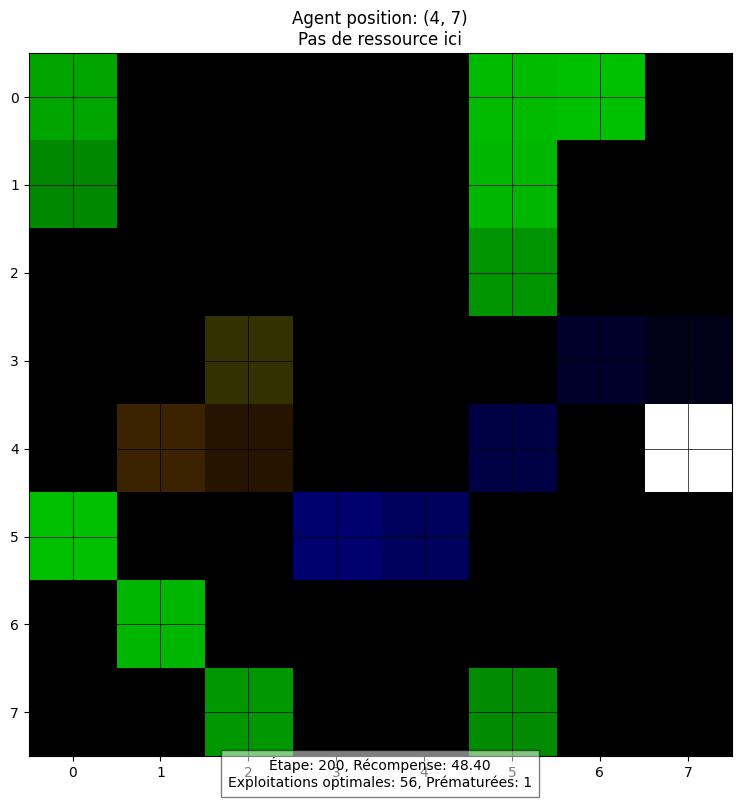

Épisode 5/5, Étape 200, Action: EXPLOIT
Type d'exploitation: optimal
Récompense: 1.09, Cumulative: 48.40
Épisode 5: Récompense = 48.40, Longueur = 200
Exploitations optimales: 56, Prématurées: 1
Ratio optimal: 0.97
---
Résultats de test: Récompense moyenne = 39.69, Ratio optimal moyen = 0.92


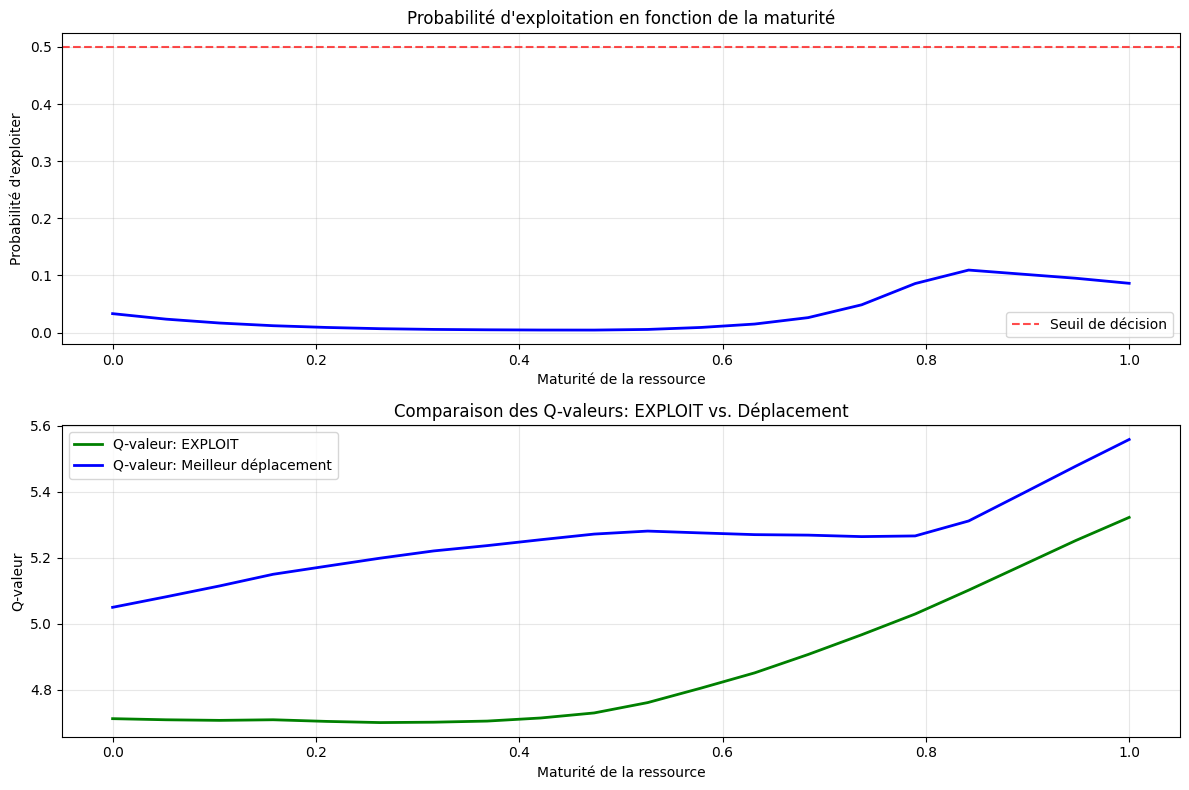

TypeError: unsupported format string passed to NoneType.__format__

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.animation as animation
from IPython.display import clear_output

class ResourceMaze:
    """Environnement de type labyrinthe avec des ressources qui se régénèrent"""
    
    def __init__(self, size=10, resource_regen_time=10, 
                 resource_density=0.3, resource_value=1.0, 
                 renewable_penalty=0.5, observation_radius=1):
        self.size = size
        self.resource_regen_time = resource_regen_time  # temps de régénération des ressources
        self.resource_density = resource_density  # densité initiale des ressources
        self.resource_value = resource_value  # valeur de base des ressources
        self.renewable_penalty = renewable_penalty  # pénalité pour exploiter une ressource non mature
        self.observation_radius = observation_radius  # rayon d'observation autour de l'agent
        
        # Initialiser la grille et les compteurs
        self.grid = np.zeros((size, size), dtype=float)  # valeur des ressources
        self.regen_timer = np.zeros((size, size), dtype=int)  # timers de régénération
        self.maturity = np.zeros((size, size), dtype=float)  # maturité des ressources (0-1)
        
        # Actions possibles: haut, bas, gauche, droite, exploiter
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'EXPLOIT']
        self.action_space = len(self.actions)
        self.action_map = {
            'UP': (-1, 0),
            'DOWN': (1, 0),
            'LEFT': (0, -1),
            'RIGHT': (0, 1),
            'EXPLOIT': (0, 0)
        }
        
        # État de l'environnement
        self.agent_pos = (size // 2, size // 2)
        self.total_steps = 0
        self.episode_steps = 0
        self.total_reward = 0
        self.optimal_exploitation = 0  # compteur d'exploitations optimales
        self.premature_exploitation = 0  # compteur d'exploitations prématurées
        
        # Génération initiale des ressources
        self._generate_resources()
    
    def _generate_resources(self):
        """Génère aléatoirement des ressources sur la grille avec différents niveaux de maturité"""
        num_resources = int(self.size * self.size * self.resource_density)
        positions = random.sample([(i, j) for i in range(self.size) for j in range(self.size)], num_resources)
        
        for pos in positions:
            if pos != self.agent_pos:  # pas de ressource à la position initiale de l'agent
                # Valeur de base de la ressource
                base_value = self.resource_value * random.uniform(0.8, 1.2)
                
                # Niveau de maturité aléatoire
                self.maturity[pos] = random.uniform(0.3, 1.0)
                
                # Valeur effective = valeur de base * maturité
                self.grid[pos] = base_value * self.maturity[pos]
    
    def reset(self):
        """Réinitialise l'environnement pour un nouvel épisode"""
        self.grid = np.zeros((self.size, self.size), dtype=float)
        self.regen_timer = np.zeros((self.size, self.size), dtype=int)
        self.maturity = np.zeros((self.size, self.size), dtype=float)
        self.agent_pos = (self.size // 2, self.size // 2)
        
        self.episode_steps = 0
        self.total_reward = 0
        self.optimal_exploitation = 0
        self.premature_exploitation = 0
        
        self._generate_resources()
        return self._get_state()
    
    def step(self, action_idx):
        """Exécute une action et retourne la nouvelle observation, la récompense et un flag de fin"""
        action = self.actions[action_idx]
        dx, dy = self.action_map[action]
        
        # Calcul de la nouvelle position
        new_x = max(0, min(self.size - 1, self.agent_pos[0] + dx))
        new_y = max(0, min(self.size - 1, self.agent_pos[1] + dy))
        new_pos = (new_x, new_y)
        
        reward = 0
        done = False
        info = {"action": action}
        
        # Si l'action est EXPLOIT
        if action == 'EXPLOIT':
            x, y = self.agent_pos
            current_resource = self.grid[x, y]
            current_maturity = self.maturity[x, y]
            
            if current_resource > 0:
                # L'agent exploite la ressource
                
                # Si la ressource est pleinement mature (> 0.8)
                if current_maturity > 0.8:
                    reward = current_resource
                    info["exploitation"] = "optimal"
                    self.optimal_exploitation += 1
                # Si la ressource est moyennement mature (0.5-0.8)
                elif current_maturity > 0.5:
                    reward = current_resource * 0.7  # rendement réduit
                    info["exploitation"] = "sub_optimal"
                # Si la ressource est immature (<0.5)
                else:
                    reward = current_resource * 0.3 - self.renewable_penalty
                    info["exploitation"] = "premature"
                    self.premature_exploitation += 1
                
                # La ressource disparaît
                self.grid[x, y] = 0
                self.maturity[x, y] = 0
                
                # Démarrer le timer de régénération
                self.regen_timer[x, y] = self.resource_regen_time
            else:
                # Pénalité pour tentative d'exploitation sans ressource
                reward = -0.2
                info["exploitation"] = "none"
        else:
            # Déplacement simple, petit coût d'action
            reward = -0.05
            self.agent_pos = new_pos
            
            # Information pour l'agent
            info["resource_observed"] = self.grid[self.agent_pos] > 0
            info["maturity_observed"] = self.maturity[self.agent_pos]
        
        # Mettre à jour les timers de régénération et régénérer les ressources
        for i in range(self.size):
            for j in range(self.size):
                # Si une ressource est en régénération
                if self.regen_timer[i, j] > 0:
                    self.regen_timer[i, j] -= 1
                    if self.regen_timer[i, j] == 0:
                        # Nouvelle valeur de base
                        base_value = self.resource_value * random.uniform(0.8, 1.2)
                        # Démarrer avec une faible maturité
                        self.maturity[i, j] = 0.3
                        # Valeur effective = valeur de base * maturité
                        self.grid[i, j] = base_value * self.maturity[i, j]
                # Si une ressource existe, augmenter sa maturité progressivement
                elif self.grid[i, j] > 0 and self.maturity[i, j] < 1.0:
                    self.maturity[i, j] = min(1.0, self.maturity[i, j] + 0.05)
                    # Ajuster la valeur en fonction de la maturité
                    base_value = self.grid[i, j] / max(0.01, self.maturity[i, j] - 0.05)
                    self.grid[i, j] = base_value * self.maturity[i, j]
        
        # Mise à jour des compteurs
        self.total_steps += 1
        self.episode_steps += 1
        self.total_reward += reward
        
        # Vérifier si l'épisode est terminé (limite de temps)
        if self.episode_steps >= 200:  # limite arbitraire
            done = True
            info["episode_steps"] = self.episode_steps
            info["total_reward"] = self.total_reward
            info["optimal_exploitation"] = self.optimal_exploitation
            info["premature_exploitation"] = self.premature_exploitation
        
        # Obtenir le nouvel état
        new_state = self._get_state()
        
        return new_state, reward, done, info
    
    def _get_state(self):
        """
        Retourne l'état observé par l'agent:
        - Position de l'agent
        - Valeur des ressources dans un rayon visible
        - Maturité des ressources dans ce même rayon
        """
        # Construction de l'état
        state = []
        
        # Position normalisée
        state.append(self.agent_pos[0] / self.size)
        state.append(self.agent_pos[1] / self.size)
        
        # Ressources et maturité visibles dans le voisinage
        r = self.observation_radius
        directions = [(dx, dy) for dx in range(-r, r+1) for dy in range(-r, r+1)]
        
        for dx, dy in directions:
            x, y = self.agent_pos[0] + dx, self.agent_pos[1] + dy
            if 0 <= x < self.size and 0 <= y < self.size:
                state.append(self.grid[x, y])
                state.append(self.maturity[x, y])
            else:
                state.append(0)  # hors limites
                state.append(0)
        
        return np.array(state, dtype=np.float32)
    
    def render(self, mode='human'):
        """Affiche l'environnement avec l'agent et les ressources"""
        plt.figure(figsize=(10, 8))
        
        # Créer une grille pour le rendu
        grid_display = np.zeros((self.size, self.size, 3))
        
        # Colorer les ressources selon leur maturité et valeur
        for i in range(self.size):
            for j in range(self.size):
                if self.grid[i, j] > 0:
                    # Valeur normalisée
                    value_intensity = min(1.0, self.grid[i, j] / (self.resource_value * 1.5))
                    
                    # Couleur selon maturité (rouge->jaune->vert)
                    if self.maturity[i, j] < 0.5:
                        # Rouge-orangé (immature)
                        r = 0.8
                        g = 0.2 + 0.6 * self.maturity[i, j]
                        b = 0
                    else:
                        # Jaune-vert (mature)
                        maturity_scaled = (self.maturity[i, j] - 0.5) * 2
                        r = 0.8 - 0.8 * maturity_scaled
                        g = 0.5 + 0.5 * maturity_scaled
                        b = 0
                    
                    grid_display[i, j] = [r * value_intensity, g * value_intensity, b * value_intensity]
                elif self.regen_timer[i, j] > 0:
                    # Ressource en régénération (bleu pâle)
                    regen_progress = 1 - (self.regen_timer[i, j] / self.resource_regen_time)
                    grid_display[i, j] = [0, 0, 0.5 * regen_progress]
        
        # Marquer la position de l'agent (blanc)
        grid_display[self.agent_pos] = [1, 1, 1]
        
        # Afficher la grille avec une bordure noire autour des cellules
        plt.imshow(grid_display)
        plt.grid(True, color='black', linewidth=0.5)
        
        # Ajouter un titre avec les informations
        x, y = self.agent_pos
        current_resource = self.grid[x, y]
        current_maturity = self.maturity[x, y]
        
        title = f"Agent position: {self.agent_pos}\n"
        if current_resource > 0:
            maturity_status = "Mature" if current_maturity > 0.8 else "Immature"
            title += f"Ressource: {current_resource:.2f}, Maturité: {current_maturity:.2f} ({maturity_status})"
        else:
            title += "Pas de ressource ici"
        
        plt.title(title)
        plt.xticks(range(self.size))
        plt.yticks(range(self.size))
        
        # Ajouter des informations de session
        info_text = f"Étape: {self.episode_steps}, Récompense: {self.total_reward:.2f}\n"
        info_text += f"Exploitations optimales: {self.optimal_exploitation}, Prématurées: {self.premature_exploitation}"
        
        plt.figtext(0.5, 0.01, info_text, ha="center", fontsize=10, 
                   bbox={"facecolor":"white", "alpha":0.5, "pad":5})
        
        plt.tight_layout()
        plt.show()


class DQN(nn.Module):
    """Réseau de neurones pour le Deep Q-Network"""
    
    def __init__(self, input_size, output_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    """Mémoire de rejeu pour stocker et échantillonner les expériences de l'agent"""
    
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Conversion en tenseurs PyTorch
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    """Agent d'apprentissage par renforcement profond utilisant DQN"""
    
    def __init__(self, state_size, action_size, hidden_size=64, 
                 learning_rate=0.001, gamma=0.99, epsilon=1.0, 
                 epsilon_decay=0.995, epsilon_min=0.1, batch_size=64,
                 update_target_every=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # Facteur d'actualisation
        self.epsilon = epsilon  # Taux d'exploration
        self.epsilon_decay = epsilon_decay  # Décroissance du taux d'exploration
        self.epsilon_min = epsilon_min  # Taux d'exploration minimum
        self.batch_size = batch_size  # Taille des lots pour l'apprentissage
        self.update_target_every = update_target_every  # Fréquence de mise à jour du réseau cible
        
        # Réseaux de neurones
        self.policy_network = DQN(state_size, action_size, hidden_size)  # Réseau principal
        self.target_network = DQN(state_size, action_size, hidden_size)  # Réseau cible
        self.target_network.load_state_dict(self.policy_network.state_dict())  # Copie initiale
        
        # Optimiseur
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        
        # Mémoire de rejeu
        self.memory = ReplayBuffer()
        
        # Compteurs
        self.steps_done = 0
        self.target_updates = 0
        
        # Historique d'apprentissage
        self.history = {
            'rewards': [],
            'losses': [],
            'epsilons': [],
            'avg_q_values': [],
            'exploitation_decisions': []  # 1:optimal, 0:suboptimal, -1:premature
        }
    
    def get_action(self, state):
        """Sélectionne une action selon la politique epsilon-greedy"""
        self.steps_done += 1
        
        # Exploration: choisir une action aléatoire
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        # Exploitation: choisir la meilleure action connue
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.policy_network(state_tensor)
            
            # Enregistrer la moyenne des valeurs Q
            self.history['avg_q_values'].append(q_values.mean().item())
            
            return q_values.max(1)[1].item()
    
    def remember(self, state, action, reward, next_state, done, info=None):
        """Enregistre une expérience dans la mémoire de rejeu"""
        self.memory.add(state, action, reward, next_state, done)
        
        # Enregistrer les décisions d'exploitation pour l'analyse
        if info and info.get('action') == 'EXPLOIT' and 'exploitation' in info:
            if info['exploitation'] == 'optimal':
                self.history['exploitation_decisions'].append(1)
            elif info['exploitation'] == 'sub_optimal':
                self.history['exploitation_decisions'].append(0)
            elif info['exploitation'] == 'premature':
                self.history['exploitation_decisions'].append(-1)
            else:
                self.history['exploitation_decisions'].append(-2)  # Pas de ressource
    
    def learn(self):
        """Entraîne le réseau à partir d'un batch d'expériences"""
        if len(self.memory) < self.batch_size:
            return 0  # Pas assez d'échantillons pour apprendre
        
        # Échantillonner des expériences
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Calcul des valeurs Q cibles
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # Calcul des valeurs Q prédites
        predicted_q_values = self.policy_network(states).gather(1, actions)
        
        # Calcul de la perte et optimisation
        loss = F.smooth_l1_loss(predicted_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping pour stabilité
        for param in self.policy_network.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()
        
        # Mise à jour du réseau cible périodiquement
        if self.steps_done % self.update_target_every == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())
            self.target_updates += 1
        
        # Décrémenter epsilon (réduire l'exploration progressivement)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()
    
    def save(self, filename):
        """Sauvegarde le modèle DQN"""
        torch.save({
            'policy_network': self.policy_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps_done': self.steps_done
        }, filename)
    
    def load(self, filename):
        """Charge un modèle DQN sauvegardé"""
        checkpoint = torch.load(filename)
        self.policy_network.load_state_dict(checkpoint['policy_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.steps_done = checkpoint['steps_done']


def train_agent(env, agent, num_episodes=500, render_every=50, learn_every=4):
    """Entraîne l'agent DQN dans l'environnement"""
    episode_rewards = []
    episode_lengths = []
    episode_losses = []
    optimal_exploits = []
    premature_exploits = []
    
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        episode_step = 0
        done = False
        
        optimal_count = 0
        premature_count = 0
        
        # Mode rendu pour cet épisode
        should_render = (episode % render_every == 0)
        
        while not done:
            # Sélectionner une action
            action = agent.get_action(state)
            
            # Exécuter l'action
            next_state, reward, done, info = env.step(action)
            
            # Enregistrer l'expérience
            agent.remember(state, action, reward, next_state, done, info)
            
            # Mettre à jour les statistiques
            episode_reward += reward
            episode_step += 1
            
            # Garder une trace des exploitations
            if info.get('exploitation') == 'optimal':
                optimal_count += 1
            elif info.get('exploitation') == 'premature':
                premature_count += 1
            
            # Apprendre périodiquement
            if episode_step % learn_every == 0:
                loss = agent.learn()
                episode_loss += loss
            
            # Mettre à jour l'état
            state = next_state
            
            # Afficher l'environnement
            if should_render and episode_step % 10 == 0:
                clear_output(wait=True)
                env.render()
                print(f"Épisode: {episode}/{num_episodes}, Étape: {episode_step}, Epsilon: {agent.epsilon:.4f}")
                plt.pause(0.01)
        
        # Statistiques finales de l'épisode
        agent.history['rewards'].append(episode_reward)
        agent.history['epsilons'].append(agent.epsilon)
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_step)
        episode_losses.append(episode_loss / max(1, episode_step // learn_every))
        optimal_exploits.append(optimal_count)
        premature_exploits.append(premature_count)
        
        if episode % 10 == 0:
            avg_reward = sum(episode_rewards[-10:]) / 10
            print(f"Épisode {episode}/{num_episodes}, Récompense moyenne (10 épisodes): {avg_reward:.2f}")
            print(f"Epsilon: {agent.epsilon:.4f}, Exploitations optimales: {optimal_count}, Prématurées: {premature_count}")
    
    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'episode_losses': episode_losses,
        'optimal_exploits': optimal_exploits,
        'premature_exploits': premature_exploits
    }


def plot_training_results(results, agent):
    """Affiche les résultats de l'entraînement"""
    plt.figure(figsize=(15, 18))
    
    # Graphique 1: Récompenses par épisode
    plt.subplot(4, 1, 1)
    plt.plot(results['episode_rewards'])
    plt.title('Récompenses par épisode')
    plt.xlabel('Épisode')
    plt.ylabel('Récompense totale')
    plt.grid(True)
    
    # Ajouter une moyenne mobile
    window_size = 10
    avg_rewards = [sum(results['episode_rewards'][max(0, i-window_size):i]) / min(i, window_size) 
                   for i in range(1, len(results['episode_rewards'])+1)]
    plt.plot(avg_rewards, 'r--', label=f'Moyenne mobile ({window_size} épisodes)')
    plt.legend()
    
    # Graphique 2: Exploitations optimales vs prématurées
    plt.subplot(4, 1, 2)
    plt.plot(results['optimal_exploits'], 'g-', label='Exploitations optimales')
    plt.plot(results['premature_exploits'], 'r-', label='Exploitations prématurées')
    plt.title('Qualité des décisions d\'exploitation')
    plt.xlabel('Épisode')
    plt.ylabel('Nombre d\'exploitations')
    plt.legend()
    plt.grid(True)
    
    # Graphique 3: Epsilon et pertes d'apprentissage
    plt.subplot(4, 1, 3)
    plt.plot(agent.history['epsilons'], 'b-', label='Epsilon (exploration)')
    
    # Normaliser les pertes pour la visualisation
    if results['episode_losses']:
        max_loss = max(filter(lambda x: x < float('inf'), results['episode_losses']))
        normalized_losses = [min(l / max_loss, 1.0) if max_loss > 0 else 0 for l in results['episode_losses']]
        plt.plot(normalized_losses, 'r-', label='Perte (normalisée)')
    
    plt.title('Paramètres d\'apprentissage')
    plt.xlabel('Épisode')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    
    # Graphique 4: Ratio d'exploitations optimales / total
    plt.subplot(4, 1, 4)
    total_exploits = [o + p for o, p in zip(results['optimal_exploits'], results['premature_exploits'])]
    exploit_ratios = [o / max(1, t) for o, t in zip(results['optimal_exploits'], total_exploits)]
    
    plt.plot(exploit_ratios, 'g-')
    plt.title('Ratio d\'exploitations optimales par rapport au total')
    plt.xlabel('Épisode')
    plt.ylabel('Ratio (0-1)')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Objectif (80%)')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def test_agent(env, agent, num_episodes=5, render_all=True):
    """Teste l'agent entraîné dans l'environnement"""
    # Désactiver l'exploration pour le test
    original_epsilon = agent.epsilon
    agent.epsilon = 0.05  # garder un peu d'exploration pour la démo
    
    test_rewards = []
    optimal_ratio = []
    
    print("\n=== Test de l'agent entraîné ===")
    
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        episode_reward = 0
        episode_step = 0
        done = False
        
        optimal_count = 0
        premature_count = 0
        total_exploits = 0
        
        while not done:
            # Sélectionner une action
            action = agent.get_action(state)
            
            # Exécuter l'action
            next_state, reward, done, info = env.step(action)
            
            # Mettre à jour les statistiques
            episode_reward += reward
            episode_step += 1
            
            # Compter les exploitations
            if 'exploitation' in info:
                if info['exploitation'] == 'optimal':
                    optimal_count += 1
                    total_exploits += 1
                elif info['exploitation'] == 'premature':
                    premature_count += 1
                    total_exploits += 1
                elif info['exploitation'] == 'sub_optimal':
                    total_exploits += 1
            
            # Afficher l'environnement
            if render_all:
                clear_output(wait=True)
                env.render()
                action_name = env.actions[action]
                print(f"Épisode {episode}/{num_episodes}, Étape {episode_step}, Action: {action_name}")
                if 'exploitation' in info:
                    print(f"Type d'exploitation: {info.get('exploitation', 'none')}")
                print(f"Récompense: {reward:.2f}, Cumulative: {episode_reward:.2f}")
                time.sleep(0.5)  # pause pour voir l'animation
            
            # Mettre à jour l'état
            state = next_state
        
# Afficher les résultats de l'épisode
        ratio = optimal_count / max(1, total_exploits)
        test_rewards.append(episode_reward)
        optimal_ratio.append(ratio)
        
        print(f"Épisode {episode}: Récompense = {episode_reward:.2f}, Longueur = {episode_step}")
        print(f"Exploitations optimales: {optimal_count}, Prématurées: {premature_count}")
        print(f"Ratio optimal: {ratio:.2f}")
        print("---")
    
    # Restaurer l'epsilon original
    agent.epsilon = original_epsilon
    
    # Afficher les résultats globaux
    avg_reward = sum(test_rewards) / len(test_rewards)
    avg_ratio = sum(optimal_ratio) / len(optimal_ratio)
    print(f"Résultats de test: Récompense moyenne = {avg_reward:.2f}, Ratio optimal moyen = {avg_ratio:.2f}")
    
    return {
        'rewards': test_rewards,
        'optimal_ratio': optimal_ratio
    }


def visualize_agent_policy(env, agent):
    """Visualise la politique apprise par l'agent sur une grille"""
    # Créer une grille pour visualiser la politique
    policy_grid = np.zeros((env.size, env.size, env.action_space))
    value_grid = np.zeros((env.size, env.size))
    
    # Pour chaque position dans la grille
    for i in range(env.size):
        for j in range(env.size):
            # Calculer les caractéristiques de l'état à cette position
            
            # Simuler 3 types d'états: sans ressource, ressource immature, ressource mature
            for resource_type in range(3):
                # Créer un état artificiel pour cette position
                state = np.zeros(agent.state_size, dtype=np.float32)
                
                # Position normalisée
                state[0] = i / env.size
                state[1] = j / env.size
                
                # Trouver l'index du centre dans le state array
                r = env.observation_radius
                center_idx = 2 + (r * 2 + 1) * r + r
                
                # Ajouter les informations de ressource au centre
                if resource_type == 1:  # Ressource immature
                    state[center_idx] = 0.5  # Valeur de la ressource
                    state[center_idx + 1] = 0.4  # Maturité faible
                elif resource_type == 2:  # Ressource mature
                    state[center_idx] = 1.0  # Valeur de la ressource
                    state[center_idx + 1] = 0.9  # Maturité élevée
                
                # Obtenir les valeurs Q pour cet état
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    q_values = agent.policy_network(state_tensor).squeeze().numpy()
                
                # Déterminer l'action avec la valeur Q maximale
                best_action = np.argmax(q_values)
                
                # Afficher les résultats
                state_label = "Vide" if resource_type == 0 else "Immature" if resource_type == 1 else "Mature"
                print(f"Position ({i},{j}), État: {state_label}")
                
                for a, action_name in enumerate(env.actions):
                    print(f"  {action_name}: Q={q_values[a]:.2f}" + (" <<<" if a == best_action else ""))
                
                # Si c'est une ressource mature, vérifier si l'agent exploite
                if resource_type == 2:
                    correct = best_action == 4  # 4 = EXPLOIT
                    print(f"  Décision pour ressource mature: {'CORRECTE (exploite)' if correct else 'INCORRECTE (n\'exploite pas)'}")
                
                # Si c'est une ressource immature, vérifier si l'agent n'exploite pas
                if resource_type == 1:
                    correct = best_action != 4  # 4 = EXPLOIT
                    print(f"  Décision pour ressource immature: {'CORRECTE (n\'exploite pas)' if correct else 'INCORRECTE (exploite)'}")
                
                print()
    
    # Créer une visualisation en heatmap des valeurs d'état
    plt.figure(figsize=(10, 8))
    plt.imshow(value_grid, cmap='viridis')
    plt.colorbar(label='Valeur d\'état estimée')
    plt.title('Carte de valeur de l\'agent')
    plt.tight_layout()
    plt.show()


def analyze_exploitation_strategy(env, agent, num_samples=20):
    """Analyse la stratégie d'exploitation de l'agent en fonction de la maturité des ressources"""
    # Préparation des données
    maturities = np.linspace(0, 1, num_samples)
    exploit_probs = []
    q_values_exploit = []
    q_values_move = []
    
    for maturity in maturities:
        # Créer un état artificiel avec une ressource à la position de l'agent
        # et une maturité variable
        state = np.zeros(agent.state_size, dtype=np.float32)
        
        # Position au centre
        state[0] = 0.5
        state[1] = 0.5
        
        # Trouver l'index du centre dans le state array
        r = env.observation_radius
        center_idx = 2 + (r * 2 + 1) * r + r
        
        # Ressource à la position actuelle
        state[center_idx] = 1.0 * maturity  # Valeur de la ressource proportionnelle à la maturité
        state[center_idx + 1] = maturity  # Maturité variable
        
        # Obtenir les valeurs Q
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = agent.policy_network(state_tensor).squeeze().numpy()
        
        # Probabilité d'exploiter (action 4)
        exploit_q = q_values[4]  # Q-valeur pour EXPLOIT
        best_move_q = max(q_values[:4])  # Q-valeur maximale pour les actions de mouvement
        
        # Calculer une probabilité softmax
        temperature = 0.1
        exploit_prob = np.exp(exploit_q / temperature) / (np.exp(exploit_q / temperature) + np.exp(best_move_q / temperature))
        
        exploit_probs.append(exploit_prob)
        q_values_exploit.append(exploit_q)
        q_values_move.append(best_move_q)
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(maturities, exploit_probs, 'b-', linewidth=2)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Seuil de décision')
    plt.title('Probabilité d\'exploitation en fonction de la maturité')
    plt.xlabel('Maturité de la ressource')
    plt.ylabel('Probabilité d\'exploiter')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(maturities, q_values_exploit, 'g-', linewidth=2, label='Q-valeur: EXPLOIT')
    plt.plot(maturities, q_values_move, 'b-', linewidth=2, label='Q-valeur: Meilleur déplacement')
    
    # Trouver le point de croisement
    crossover_idx = None
    for i in range(len(maturities) - 1):
        if (q_values_exploit[i] < q_values_move[i] and 
            q_values_exploit[i+1] >= q_values_move[i+1]):
            crossover_idx = i
            break
    
    cross_x = None
    if crossover_idx is not None:
        # Interpolation linéaire pour trouver le point de croisement exact
        x1, y1 = maturities[crossover_idx], q_values_exploit[crossover_idx]
        x2, y2 = maturities[crossover_idx+1], q_values_exploit[crossover_idx+1]
        x3, y3 = maturities[crossover_idx], q_values_move[crossover_idx]
        x4, y4 = maturities[crossover_idx+1], q_values_move[crossover_idx+1]
        
        # Point d'intersection
        cross_x = x1 + (x2 - x1) * (y3 - y1) / ((y2 - y1) - (y4 - y3))
        cross_y = y1 + (y2 - y1) * (cross_x - x1) / (x2 - x1)
        
        plt.axvline(x=cross_x, color='r', linestyle='--', alpha=0.7, 
                   label=f'Seuil de maturité: {cross_x:.2f}')
        plt.plot(cross_x, cross_y, 'ro')
    
    plt.title('Comparaison des Q-valeurs: EXPLOIT vs. Déplacement')
    plt.xlabel('Maturité de la ressource')
    plt.ylabel('Q-valeur')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'maturities': maturities,
        'exploit_probs': exploit_probs,
        'q_values_exploit': q_values_exploit,
        'q_values_move': q_values_move,
        'threshold': cross_x if crossover_idx is not None else None
    }


def create_animated_policy_heatmap(env, agent, animation_frames=20):
    """Crée une animation montrant l'évolution de la politique d'exploitation avec la maturité"""
    # Préparation
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Pour chaque niveau de maturité, calculer la politique sur la grille
    frames = []
    maturities = np.linspace(0, 1, animation_frames)
    
    for maturity in maturities:
        # Créer une grille de décisions
        policy_grid = np.zeros((env.size, env.size))
        
        # Pour chaque position dans la grille
        for i in range(env.size):
            for j in range(env.size):
                # Créer un état artificiel pour cette position avec une ressource de maturité donnée
                state = np.zeros(agent.state_size, dtype=np.float32)
                
                # Position normalisée
                state[0] = i / env.size
                state[1] = j / env.size
                
                # Trouver l'index du centre dans le state array
                r = env.observation_radius
                center_idx = 2 + ((2*r+1)**2) // 2
                
                # Ajouter les informations de ressource
                state[center_idx] = 1.0 * maturity  # Valeur
                state[center_idx + 1] = maturity    # Maturité
                
                # Obtenir les valeurs Q et l'action optimale
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    q_values = agent.policy_network(state_tensor).squeeze().numpy()
                
                # Décider si l'agent exploite (1) ou se déplace (0)
                best_action = np.argmax(q_values)
                exploit_q = q_values[4]  # EXPLOIT
                best_move_q = max(q_values[:4])  # meilleur mouvement
                
                # Calculer une valeur d'intensité basée sur la différence
                q_diff = exploit_q - best_move_q
                policy_grid[i, j] = 1 / (1 + np.exp(-q_diff * 5))  # fonction sigmoïde
        
        # Créer l'image
        im = ax.imshow(policy_grid, cmap='RdYlGn', vmin=0, vmax=1)
        title = ax.set_title(f"Politique d'exploitation (maturité = {maturity:.2f})")
        frames.append([im, title])
    
    # Créer l'animation
    ani = animation.ArtistAnimation(fig, frames, interval=200, blit=False)
    
    # Ajouter une barre de couleur et des étiquettes
    plt.colorbar(im, ax=ax, label='Probabilité d\'exploitation')
    ax.set_xlabel('Position X')
    ax.set_ylabel('Position Y')
    
    plt.tight_layout()
    return ani


def main():
    # Configuration
    env_size = 8  # Taille de l'environnement
    resource_density = 0.3  # Densité des ressources
    observation_radius = 1  # Rayon d'observation
    
    # Créer l'environnement
    env = ResourceMaze(
        size=env_size,
        resource_regen_time=15,
        resource_density=resource_density,
        resource_value=1.0,
        renewable_penalty=0.3,
        observation_radius=observation_radius
    )
    
    # Calculer la taille de l'état
    state_size = 2 + (2*observation_radius+1)**2 * 2  # position (2) + ressources et maturité dans le voisinage
    
    # Créer l'agent DQN
    agent = DQNAgent(
        state_size=state_size,
        action_size=env.action_space,
        hidden_size=128,
        learning_rate=0.001,
        gamma=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.1,
        batch_size=64,
        update_target_every=10
    )
    
    # Entraîner l'agent
    print("Début de l'entraînement...")
    results = train_agent(env, agent, num_episodes=200, render_every=20)
    
    # Afficher les résultats
    plot_training_results(results, agent)
    
    # Tester l'agent entraîné
    test_agent(env, agent, num_episodes=5, render_all=True)
    
    # Analyser la stratégie d'exploitation
    threshold = analyze_exploitation_strategy(env, agent)
    print(f"Seuil de maturité pour l'exploitation: {threshold['threshold']:.2f}")
    
    # Sauvegarder l'agent entraîné
    agent.save("dqn_resource_agent.pt")
    print("Agent sauvegardé dans dqn_resource_agent.pt")


if __name__ == "__main__":
    main()

In [6]:
# main.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from env import RandomizedGridMaze
from agents_policies import QAgent, DQNAgent, SocialRewardCalculator
import os
import time
from datetime import datetime

def run_simulation(env_params, agent_params, num_episodes=100, max_steps=100, 
                   save_dir='results', eval_interval=10):
    """
    Run a simulation with given parameters and save results to CSV
    
    Args:
        env_params: Dictionary of environment parameters
        agent_params: Dictionary of agent parameters
        num_episodes: Number of episodes to run
        max_steps: Maximum steps per episode
        save_dir: Directory to save results
        eval_interval: Interval to evaluate and print stats
    
    Returns:
        DataFrame with simulation results
    """
    # Create results directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Create environment
    env = RandomizedGridMaze(**env_params)
    
    # Create agents based on type
    agents = []
    for i in range(env_params['nb_agents']):
        if agent_params['type'] == 'QAgent':
            agents.append(QAgent(
                state_size=10,  # Based on agent's get_state method
                action_size=env.number_actions,
                agent_id=i,
                learning_rate=agent_params.get('learning_rate', 0.1),
                gamma=agent_params.get('gamma', 0.99),
                epsilon=agent_params.get('epsilon', 1.0),
                epsilon_decay=agent_params.get('epsilon_decay', 0.995),
                epsilon_min=agent_params.get('epsilon_min', 0.01)
            ))
        elif agent_params['type'] == 'DQNAgent':
            agents.append(DQNAgent(
                state_size=10,  # Based on agent's get_state method
                action_size=env.number_actions,
                agent_id=i,
                hidden_size=agent_params.get('hidden_size', 64),
                learning_rate=agent_params.get('learning_rate', 0.001),
                gamma=agent_params.get('gamma', 0.99),
                epsilon=agent_params.get('epsilon', 1.0),
                epsilon_decay=agent_params.get('epsilon_decay', 0.995),
                epsilon_min=agent_params.get('epsilon_min', 0.01),
                batch_size=agent_params.get('batch_size', 64)
            ))
    
    # Create social reward calculator if needed
    if agent_params.get('use_social_rewards', False):
        social_calculator = SocialRewardCalculator(
            nb_agents=env_params['nb_agents'],
            alpha=agent_params.get('social_alpha', 0.5),
            beta=agent_params.get('social_beta', 0.5),
            threshold=agent_params.get('social_threshold', 0.7)
        )
    
    # Initialize data collection
    results = []
    
    # Run episodes
    for episode in range(num_episodes):
        env.new_episode()
        episode_rewards = [0] * env_params['nb_agents']
        episode_steps = 0
        episode_meals = [0] * env_params['nb_agents']
        
        # Get initial states for all agents
        states = [env.agents[i].get_state(env) for i in range(env_params['nb_agents'])]
        
        # Start episode for all agents
        actions = [agents[i].start_episode(states[i]) for i in range(env_params['nb_agents'])]
        
        # Episode loop
        for step in range(max_steps):
            episode_steps += 1
            
            # Execute actions for all agents
            next_states = []
            for i in range(env_params['nb_agents']):
                # Make step in environment
                reward, new_pos = env.make_step(i, actions[i])
                episode_rewards[i] += reward
                
                if reward > 0:
                    episode_meals[i] += 1
                
                # Get new state
                next_state = env.agents[i].get_state(env)
                next_states.append(next_state)
            
            # Apply social rewards if enabled
            if agent_params.get('use_social_rewards', False):
                _, _, _, social_rewards = social_calculator.calculate_rewards(env.agents)
                
                # Update rewards with social component
                for i in range(env_params['nb_agents']):
                    # Note: we don't add to episode_rewards since these are internal learning signals
                    reward = social_rewards[i]
            
            # Update environment (resource respawn, etc.)
            env.update_environment()
            
            # Get next actions from agents
            for i in range(env_params['nb_agents']):
                # Step the agent with appropriate reward
                reward = episode_rewards[i] if not agent_params.get('use_social_rewards', False) else social_rewards[i]
                done = (step == max_steps - 1)
                actions[i] = agents[i].step(reward, next_states[i], done)
            
            # Update states
            states = next_states
        
        # Collect episode results
        for i in range(env_params['nb_agents']):
            results.append({
                'episode': episode,
                'agent_id': i,
                'total_reward': episode_rewards[i],
                'meals_consumed': episode_meals[i],
                'recent_meals': env.agents[i].get_recent_meals(),
                'exploration_rate': agents[i].epsilon if hasattr(agents[i], 'epsilon') else None,
                'steps': episode_steps
            })
        
        # Print progress periodically
        if episode % eval_interval == 0 or episode == num_episodes - 1:
            avg_reward = np.mean([r['total_reward'] for r in results if r['episode'] == episode])
            avg_meals = np.mean([r['meals_consumed'] for r in results if r['episode'] == episode])
            print(f"Episode {episode}/{num_episodes} - Avg Reward: {avg_reward:.2f}, Avg Meals: {avg_meals:.2f}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"simulation_{agent_params['type']}_{timestamp}.csv"
    filepath = os.path.join(save_dir, filename)
    results_df.to_csv(filepath, index=False)
    print(f"Results saved to {filepath}")
    
    return results_df

def plot_results(results_df, save_dir='results'):
    """
    Plot simulation results and save figures
    
    Args:
        results_df: DataFrame with simulation results
        save_dir: Directory to save plots
    """
    # Create average results per episode
    episode_results = results_df.groupby('episode').agg({
        'total_reward': 'mean',
        'meals_consumed': 'mean',
        'recent_meals': 'mean',
        'exploration_rate': 'mean'
    }).reset_index()
    
    # Plot reward over episodes
    plt.figure(figsize=(10, 6))
    plt.plot(episode_results['episode'], episode_results['total_reward'])
    plt.title('Average Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'rewards.png'))
    
    # Plot meals over episodes
    plt.figure(figsize=(10, 6))
    plt.plot(episode_results['episode'], episode_results['meals_consumed'])
    plt.title('Average Meals Consumed per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Meals')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'meals.png'))
    
    # Plot exploration rate if available
    if not episode_results['exploration_rate'].isnull().all():
        plt.figure(figsize=(10, 6))
        plt.plot(episode_results['episode'], episode_results['exploration_rate'])
        plt.title('Exploration Rate (Epsilon) over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.grid(True)
        plt.savefig(os.path.join(save_dir, 'exploration.png'))

if __name__ == "__main__":
    # Define environment parameters
    env_params = {
        'size': 10,                 # 10x10 grid
        'nb_agents': 5,             # 5 agents
        'reward_density': 0.3,      # 30% of cells have resources
        'respawn_prob': 0.1,        # 10% chance of respawn per step
        'simple_mode': False,       # Use complex resource dynamics
        'auto_consume': True,       # Automatically consume resources
        'exploit_only': False       # Allow consumption with any action
    }
    
    # Define agent parameters
    agent_params = {
        'type': 'DQNAgent',          # Use DQN agents
        'learning_rate': 0.001,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_decay': 0.995,
        'epsilon_min': 0.1,
        'hidden_size': 128,
        'batch_size': 64,
        'use_social_rewards': True,  # Use social rewards
        'social_alpha': 0.3,         # Weight for social vs individual reward
        'social_beta': 0.7,          # Weight for immediate vs historical satisfaction
        'social_threshold': 0.5      # Threshold for satisfaction
    }
    
    # Run simulation
    print("Starting simulation...")
    start_time = time.time()
    results = run_simulation(
        env_params=env_params,
        agent_params=agent_params,
        num_episodes=200,
        max_steps=100,
        eval_interval=10
    )
    end_time = time.time()
    print(f"Simulation completed in {end_time - start_time:.2f} seconds")
    
    # Plot results
    print("Generating plots...")
    plot_results(results)
    print("Plots saved to results directory")
    
    # Run a comparison with QAgent
    print("\nRunning comparison with QAgent...")
    agent_params['type'] = 'QAgent'
    agent_params['learning_rate'] = 0.1
    agent_params['epsilon_decay'] = 0.99
    
    start_time = time.time()
    qagent_results = run_simulation(
        env_params=env_params,
        agent_params=agent_params,
        num_episodes=200,
        max_steps=100,
        eval_interval=10
    )
    end_time = time.time()
    print(f"QAgent simulation completed in {end_time - start_time:.2f} seconds")
    
    # Plot QAgent results
    print("Generating QAgent plots...")
    plot_results(qagent_results)
    print("All simulations completed!")

Starting simulation...


AttributeError: 'SocialRewardCalculator' object has no attribute 'calculate_rewards'